In [16]:
import re
import os
import sys
import h5py
import time
import numpy as np
import scipy as sp
from utils import *
import mindspore as ms
from numpy.linalg import inv, norm
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.linalg import expm, sqrtm
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindspore.common.initializer import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from mindquantum.algorithm.compiler.decompose.utils import *

np.set_printoptions(linewidth=200)

[[0.34880034+0.j         0.40977999-0.24334959j]
 [0.40977999+0.24334959j 0.65119966+0.j        ]] (1+0j)
[[-0.30155987-0.50780113j  0.70856123+0.38618732j]
 [ 0.69384473+0.41204265j  0.59059321+0.j        ]] (0.28903334387559965-0.5078011293587639j)
[0.53639729-0.17207415j 0.7502259 +0.17207415j]
[0.28779342-0.08599395j 0.90823478+0.29135815j]
[[-0.30155987-0.50780113j  0.70856123+0.38618732j]
 [ 0.69384473+0.41204265j  0.59059321+0.j        ]] (0.28903334387559965-0.5078011293587639j)


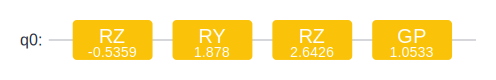

In [17]:
r = h5py.File('mat/322_d2_num1_model957_RDM_v7.3.mat', 'r')
l = list(r.keys())
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

np.random.seed(42)
gate = np.random.rand(2) + 1j * np.random.rand(2)
gate /= norm(gate)
gate = np.outer(gate.conj(), gate)
print(gate, np.trace(gate))
gate_u = UnivMathGate('gate', gate).on(0)
gate_d = euler_decompose(gate_u)
print(gate_d.matrix(), np.trace(gate_d.matrix()))

circ_u = Circuit() + gate_u
circ_d = Circuit() + gate_d
sim_u = Simulator('mqvector', 1)
sim_u.apply_gate(H(0))
sim_u.apply_circuit(circ_u)
print(sim_u.get_qs())
sim_d = Simulator('mqvector', 1)
sim_d.apply_gate(H(0))
sim_d.apply_circuit(circ_d)
print(sim_d.get_qs())
print(circ_d.matrix(), np.trace(circ_d.matrix()))

circ_d.svg()

[[ 0.27702459-0.13059069j -0.76350488+0.56856287j]
 [ 0.36122517+0.88074958j  0.1700831 +0.25469254j]]
[[ 0.27702459-0.13059069j -0.76350488+0.56856287j]
 [ 0.36122517+0.88074958j  0.1700831 +0.25469254j]]
[[1.-8.19750498e-17j 1.+1.87079558e-16j]
 [1.-2.15807712e-16j 1.-2.26100146e-16j]] True


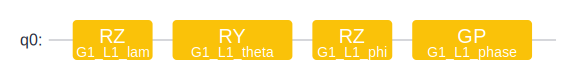

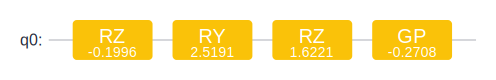

In [18]:
def decompose_zyz(mat: np.array):
    d = mat.shape[0]
    if not np.allclose(np.eye(d), mat @ mat.conj().T):
        raise ValueError('The gate is not unitary')
    phase = -np.angle(det(mat)) / 2
    matU = mat * np.exp(1j * phase)
    cos = np.sqrt(np.real(matU[0, 0] * matU[1, 1]))
    theta = 2 * np.arccos(cos)
    phi = np.angle(matU[1, 1]) + np.angle(matU[1, 0])
    lam = np.angle(matU[1, 1]) - np.angle(matU[1, 0])
    return phase, theta, phi, lam


def decompose_u3(mat: np.array):
    phase, theta, phi, lam = decompose_zyz(mat)
    phase += (phi + lam) / 2
    return phase, theta, phi, lam


def one_qubit_decompose(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = True) -> Circuit:
    name_phase = gate.name + '_phase'
    name_theta = gate.name + '_theta'
    name_phi = gate.name + '_phi'
    name_lam = gate.name + '_lam'
    obj = gate.obj_qubits
    mat = gate.matrix()
    circ = Circuit()
    if basis == 'zyz':
        phase, theta, phi, lam = decompose_zyz(mat)
        circ += RZ(name_lam).on(obj)
        circ += RY(name_theta).on(obj)
        circ += RZ(name_phi).on(obj)
    elif basis == 'u3':
        circ += U3(name_theta, name_phi, name_lam).on(obj)
        phase, theta, phi, lam = decompose_u3(mat)
    else:
        raise ValueError(f'{basis} is not a supported decomposition method of {optional_basis}')
    if with_phase:
        circ += GlobalPhase(name_phase).on(obj)
    pr = {name_phase: phase, name_phi: phi, name_theta: theta, name_lam: lam}
    return circ, pr


d = 2
gate = unitary_group.rvs(d, random_state=42)
print(gate)
gate_u = UnivMathGate('G1_L1', gate).on(0)
gate_d, pr = one_qubit_decompose(gate_u, 'zyz')
gate_mat = gate_d.matrix(pr)
print(gate_mat)
print(gate / gate_mat, np.allclose(gate, gate_mat))
display_svg(gate_d.svg())
gate_d.apply_value(pr).svg()

[[ 0.23648826-0.48221431j  0.06829648+0.04447898j  0.51150074-0.09529866j  0.55205719-0.35974699j]
 [-0.11148167+0.69780321j -0.24943828+0.08410701j  0.46705929-0.43192981j  0.16220654-0.01817602j]
 [-0.22351926-0.25918352j  0.24364996-0.05375623j -0.09259829-0.53810588j  0.27267708+0.66941977j]
 [ 0.11519953-0.28596729j -0.90164923-0.22099186j -0.09627758-0.13105595j -0.0200152 +0.12766128j]]
[[ 0.23648826-0.48221431j  0.06829648+0.04447898j  0.51150074-0.09529866j  0.55205719-0.35974699j]
 [-0.11148167+0.69780321j -0.24943828+0.08410701j  0.46705929-0.43192981j  0.16220654-0.01817602j]
 [-0.22351926-0.25918352j  0.24364996-0.05375623j -0.09259829-0.53810588j  0.27267708+0.66941977j]
 [ 0.11519953-0.28596729j -0.90164923-0.22099186j -0.09627758-0.13105595j -0.0200152 +0.12766128j]]
[[1.+7.88783220e-16j 1.-1.35547572e-15j 1.+4.71983645e-16j 1.+8.46975206e-16j]
 [1.-6.78749759e-16j 1.+9.99128141e-16j 1.-5.76571597e-16j 1.-1.56316361e-15j]
 [1.-1.16685605e-15j 1.-1.11343781e-15j 1.-1.402

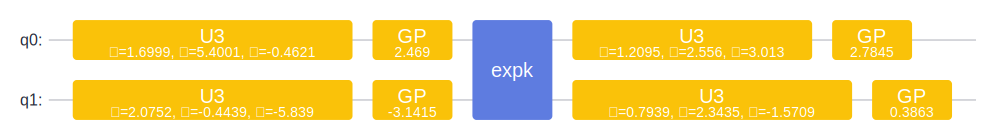

In [223]:
def two_qubit_decompose(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = True) -> Circuit:
    A = np.array([[1, 1, -1, 1], [1, 1, 1, -1], [1, -1, -1, -1], [1, -1, 1, 1]])
    M = np.array([[1, 0, 0, 1j], [0, 1j, 1, 0], [0, 1j, -1, 0], [1, 0, 0, -1j]]) / np.sqrt(2)
    X_mat = X.matrix()
    Y_mat = Y.matrix()
    Z_mat = Z.matrix()
    XX_mat = np.kron(X_mat, X_mat)
    YY_mat = np.kron(Y_mat, Y_mat)
    ZZ_mat = np.kron(Z_mat, Z_mat)
    name_phase = gate.name + '_phase'
    name_theta = gate.name + '_theta'
    name_phi = gate.name + '_phi'
    name_lam = gate.name + '_lam'
    obj0, obj1 = gate.obj_qubits
    mat = gate.matrix()
    circ = Circuit()
    u_su4 = M.conj().T @ mat @ M
    ur = np.real(u_su4)
    ui = np.imag(u_su4)
    (q_left, q_right), (dr, di) = simult_svd(ur, ui)
    d = dr + 1j * di
    _, a1, a0 = kron_factor_4x4_to_2x2s(M @ q_left @ M.conj().T)
    _, b1, b0 = kron_factor_4x4_to_2x2s(M @ q_right.T @ M.conj().T)
    k = (A.T / 4) @ np.angle(np.diag(d))
    expk = expm(1j * (k[0] * np.eye(4) + k[1] * XX_mat + k[2] * YY_mat + k[3] * ZZ_mat))
    h1, h2, h3 = -k[1:]
    u0 = 1j / np.sqrt(2) * (X_mat + Z_mat) @ expm(-1j * (h1 - np.pi / 4) * X_mat)
    v0 = -1j / np.sqrt(2) * (X_mat + Z_mat)
    u1 = expm(-1j * h3 * Z_mat)
    v1 = expm(1j * h2 * Z_mat)
    w = (np.eye(2) - 1j * X_mat) / np.sqrt(2)
    rots0 = [b0, u0, v0, a0 @ w]
    rots1 = [b1, u1, v1, a1 @ w.conj().T]
    circ += UnivMathGate('B0', b0).on(obj0)
    circ += UnivMathGate('B1', b1).on(obj1)
    circ += UnivMathGate('expk', expk).on([obj0, obj1])
    circ += UnivMathGate('A0', a0).on(obj0)
    circ += UnivMathGate('A1', a1).on(obj1)
    if basis == 'zyz':
        circ_zyz = Circuit()
        for i in circ:
            if len(i.obj_qubits) == 1:
                # print(one_qubit_decompose(i))
                circ_zyz += euler_decompose(i, 'zyz')
            else:
                circ_zyz += i
        return circ_zyz
    elif basis == 'u3':
        circ_u3 = Circuit()
        for i in circ:
            if len(i.obj_qubits) == 1:
                # print(one_qubit_decompose(i))
                circ_u3 += euler_decompose(i, 'u3')
            else:
                circ_u3 += i
        return circ_u3
    else:
        # raise ValueError(f'{basis} is not a supported decomposition method of {optional_basis}')
    # pr = {name_phase: phase, name_phi: phi, name_theta: theta, name_lam: lam}
        return circ


d = 4
gate = unitary_group.rvs(d, random_state=42)
print(gate)
gate_u = UnivMathGate('gate', gate).on([0, 1])
gate_d = two_qubit_decompose(gate_u, 'u3')
# gate_mat = gate_d.matrix(pr)
# print(gate_mat)
print(gate_d.matrix())
print(gate / gate_d.matrix(), np.allclose(gate, gate_d.matrix()))
display_svg(gate_d.svg())
# gate_d.apply_value(pr).svg()